# Overview

What separates the Hall of Fame from the Hall of Very Good? In this exploration, I look at the set of players who were nominated for entry into baseball's Hall of Fame. 

In this report, we find correlations among pitching, fielding, batting statistics, and awards with entry into the Hall of Fame. We also explore how they break down by position and explore whether or not the steroids era of baseball has had any effect.

TK: Add in conclusions

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline
pd.set_option('display.max_columns', None)

# Data Wrangling
The dataset consists of pitching, hitting, and fielding statistics for Major League Baseball from 1871 through 2014. Each table is represented by a CSV file, with playerID being a unique ID we can use for merging.

To wrangle this data together, I performed the following steps:

* Load the Hall of Fame table.
* Merge in Master to add names.
* Merge in Award information.
* Merge in Appearances.
* Merge in Pitching statistics.
* Merge in Batting statistics.
* Merge in Fielding statistics.

## Master

In [142]:
hof_df = pd.read_csv('baseballdatabank-master/core/HallOfFame.csv')
master_df = pd.read_csv('baseballdatabank-master/core/Master.csv', parse_dates=['debut', 'finalGame'])

hof_cols = ['playerID', 'nameFirst', 'nameLast'] + list(hof_df.columns[1:]) 

hof_df = hof_df.merge(master_df, on='playerID')
hof_df = hof_df[hof_cols]

hof_df.head()

,playerID,nameFirst,nameLast,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,Ty,Cobb,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,Babe,Ruth,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,Honus,Wagner,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,wagneho01,Honus,Wagner,1936,Veterans,78.0,59.0,5.0,N,Player,NaN
4,mathech01,Christy,Mathewson,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN


Since each row in the Hall of Fame set reflects a voting record, we group by playerID to remove duplicate rows. We end up with a single data frame of players, where the `inducted` field marks whether or not they are in the Hall of Fame.

There are 247 inducted players and 941 non-inducted players in this dataset.

In [143]:
player_votes = hof_df.loc[(hof_df.category == 'Player')]
inducted_players = hof_df.loc[(hof_df.inducted == 'Y') & (hof_df.category == 'Player')]

non_inducted_ids = set(player_votes.playerID).difference(inducted_players.playerID)

non_inducted_players = player_votes.loc[hof_df.playerID.isin(non_inducted_ids)]
non_inducted_players = non_inducted_players.groupby('playerID', as_index=False).last()

print("# of Inducted Players: %d" % inducted_players.shape[0])
print("# of Non-Inducted Players: %d" % non_inducted_players.shape[0])

nominated_players = inducted_players.append(non_inducted_players, ignore_index=True)
display(nominated_players.shape)

# of Inducted Players: 247
# of Non-Inducted Players: 941


(1188, 11)

## Awards
We add in Awards players won over the course of their career. It seems plausible that awards would be correlated with entrance into the Hall.

In [144]:
awards = pd.read_csv("baseballdatabank-master/core/AwardsPlayers.csv")

award_count = awards.groupby('playerID').size().reset_index()
award_count.columns = ['playerID', 'Awards']

# Convert each award into a column, value will be the count.
award_columns = awards[['playerID', 'awardID']].pivot_table(index='playerID', columns='awardID', 
                                                            aggfunc=np.count_nonzero, fill_value=0)

nominated_players = pd.merge(nominated_players, award_columns.reset_index(), on='playerID', how='left')
nominated_players = pd.merge(nominated_players, award_count, on='playerID', how='left')

# Not all players will get awards, so fill missing values with 0. 
# Note: needed_note field will also get replaced, but I don't use this field, so it's okay.
nominated_players.fillna(0, inplace=True)

nominated_players.head()

,playerID,nameFirst,nameLast,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards
0,cobbty01,Ty,Cobb,1936,BBWAA,226.0,170.0,222.0,Y,Player,0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.0
1,ruthba01,Babe,Ruth,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0
2,wagneho01,Honus,Wagner,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
3,mathech01,Christy,Mathewson,1936,BBWAA,226.0,170.0,205.0,Y,Player,0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
4,johnswa01,Walter,Johnson,1936,BBWAA,226.0,170.0,189.0,Y,Player,0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0


Here, we separate players into two buckets, i.e. whether they are inducted or not. 

When we look at summary stasticis below, it seems like inducted players on average receive more awards than non-inducted players. 

In [145]:
display(nominated_players[nominated_players.inducted == 'Y'].Awards.describe())
display(nominated_players[nominated_players.inducted == 'N'].Awards.describe())

count    247.000000
mean       9.210526
std        9.297489
min        0.000000
25%        1.000000
50%        7.000000
75%       14.000000
max       39.000000
Name: Awards, dtype: float64

count    941.000000
mean       2.380446
std        3.611713
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       47.000000
Name: Awards, dtype: float64

When we visualize these using a histogram, we see that both distributions are skewed to the right. The largest bin for both represents winning just a few awards. However, the inducted players have a much longer tail, with a player winning 39 awards.

In [146]:
def plot_awards(df, title, bins=20):
    ax = df['Awards'].hist(bins=bins)
    ax.set_xlabel("Number of Awards")
    ax.set_ylabel("Count")
    ax.set_title(title)

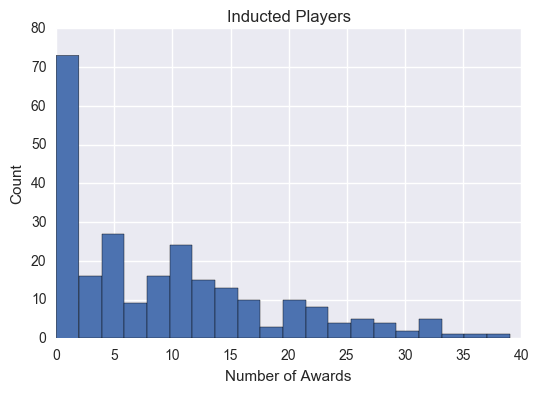

In [147]:
plot_awards(nominated_players[nominated_players.inducted == 'Y'], 'Inducted Players')

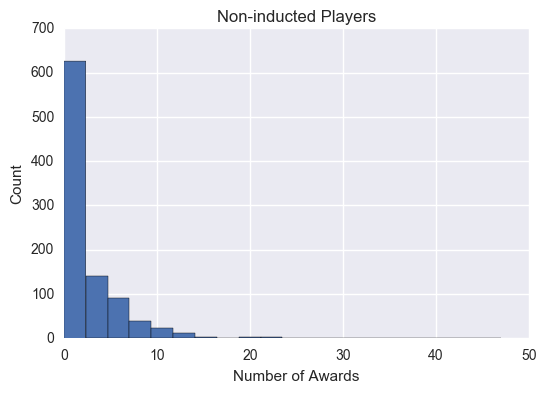

In [148]:
plot_awards(nominated_players[nominated_players.inducted == 'N'], 'Non-inducted Players')

# Appearances
Number of games played could approximate longevity, which Hall voters could be rewarding.

In [149]:
def cumulative_stats(csv_path, display_head=True, agg_dict=None):
    """Computes aggregate stats from a CSV.
    
    Loads a CSV denoted by csv_path, groups by playerID. By default, numeric
    columns will be summed unless functions are specified in agg_dict.
    """
    df = pd.read_csv(csv_path)
    
    if display_head == True:
        display(df.head())
    
    df_total = None
    
    if agg_dict is None:
        df_total = df.groupby('playerID', as_index=False).sum()
        del df_total['yearID']
    else:
        df_total = df.groupby('playerID', as_index=False).agg(agg_dict)
    
    return df_total

# Merge with Appearances
appearances_total = cumulative_stats("baseballdatabank-master/core/Appearances.csv", display_head=False)
appearances_total.fillna(0, inplace=True)

appearances_total.head()

,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,aardsda01,331.0,0.0,139,331.0,331,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,aaronha01,3298.0,288.0,3298,3057.0,0,0,210,43,7,0,313,293,2184,2760,196.0,46.0,0.0
2,aaronto01,437.0,0.0,437,437.0,0,0,232,7,10,0,136,1,2,138,0.0,0.0,0.0
3,aasedo01,448.0,0.0,81,448.0,448,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,abadan01,15.0,4.0,15,9.0,0,0,8,0,0,0,0,0,1,1,0.0,7.0,1.0


## Positions
We also use the appearances data to determine the player's most played position. We will use this to compare traits amongst players later.

In [150]:
nominated_players = pd.merge(nominated_players, appearances_total, on='playerID')

# position_cols = ['G_p','G_c','G_1b','G_2b',
#                  'G_3b','G_ss','G_lf','G_cf',
#                  'G_rf','G_of','G_dh','G_ph','G_pr']

position_cols = ['G_p','G_c','G_1b','G_2b',
                 'G_3b','G_ss','G_of','G_dh','G_ph','G_pr']

def most_played_position(df):
    return df[position_cols].idxmax(axis=1).str.split('_').str[1].str.upper()

nominated_players.insert(3, 'Position', most_played_position(nominated_players))
display(nominated_players.head())

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,cobbty01,Ty,Cobb,OF,1936,BBWAA,226.0,170.0,222.0,Y,Player,0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.0,3034.0,0.0,3034,3034.0,3,0,14,2,1,0,35,2194,706,2934,0.0,0.0,0.0
1,ruthba01,Babe,Ruth,OF,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,2503.0,0.0,2503,2503.0,163,0,32,0,0,0,1057,64,1131,2241,0.0,0.0,0.0
2,wagneho01,Honus,Wagner,SS,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2794.0,0.0,2794,2794.0,2,0,248,57,210,1887,35,67,272,373,0.0,0.0,0.0
3,mathech01,Christy,Mathewson,P,1936,BBWAA,226.0,170.0,205.0,Y,Player,0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,647.0,0.0,647,647.0,636,0,3,0,0,0,1,0,3,4,0.0,0.0,0.0
4,johnswa01,Walter,Johnson,P,1936,BBWAA,226.0,170.0,189.0,Y,Player,0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,934.0,0.0,934,934.0,802,0,0,0,0,0,2,7,4,13,0.0,0.0,0.0


Out of all the positions, we can see that pitchers are represented the most in our dataset:

In [151]:
nominated_players.Position.value_counts()

P     394
OF    297
C     101
1B    100
2B     88
3B     86
SS     84
DH      8
PH      4
Name: Position, dtype: int64

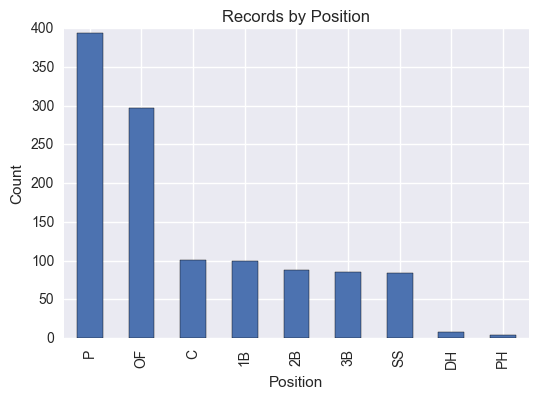

In [152]:
ax = nominated_players.Position.value_counts().plot.bar()
ax.set_title("Records by Position")
ax.set_ylabel("Count")
ax.set_xlabel("Position");

## Pitching

In [153]:
agg_dict = {'ERA': np.mean, 'W': np.sum, 'L': np.sum}
pitching_total = cumulative_stats("baseballdatabank-master/core/Pitching.csv", 
                                  display_head=False,
                                  agg_dict=agg_dict)

nominated_players = pd.merge(nominated_players, pitching_total, on='playerID', how='left')

## Batting
I merged in hitting statistics and computed the common sabermetric statistics of on-base percentage (OBP), slugging percentage (SLG), and on-base plus slugging (OPS).

In [33]:
def slugging_pct(df):
    return ((df['H'] - df['2B'] - df['3B'] - df['HR']) + 2*df['2B'] + 3*df['3B'] + 4*df['HR']) / df['AB']

def on_base_pct(df):
    return (df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['SF'] + df['HBP'])

def on_base_plus_slugging(df):
    return on_base_pct(df) + slugging_pct(df)

def add_hitting_stats(df):
    df['BA'] = df.H / df.AB
    df['SLG'] = slugging_pct(df)
    df['OBP'] = on_base_pct(df)
    df['OPS'] = on_base_plus_slugging(df)

In [34]:
batting_total = cumulative_stats("baseballdatabank-master/core/Batting.csv", 
                                  display_head=False)

nominated_players = pd.merge(nominated_players, batting_total, on='playerID', how='left')

nominated_players.fillna(0, inplace=True)

add_hitting_stats(nominated_players)

# Fielding

In [35]:
fielding_total = cumulative_stats("baseballdatabank-master/core/Fielding.csv", display_head=False)

fielding_total['E/G'] = fielding_total['E'] / fielding_total['G']
fielding_total['ZR/G'] = fielding_total['ZR'] / fielding_total['G']

fielding_total.rename(columns = {'CS': 'Opponent CS', 'SB': 'Opponent SB'}, inplace = True)

nominated_players = pd.merge(nominated_players, fielding_total, on='playerID', how='left')

nominated_players.head()

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards,G_all,GS_x,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,ERA,W,L,stint_x,G_x,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,BA,SLG,OBP,OPS,stint_y,G_y,GS_y,InnOuts,PO,A,E,DP,PB,WP,Opponent SB,Opponent CS,ZR,E/G,ZR/G
0,cobbty01,Ty,Cobb,OF,1936,BBWAA,226.0,170.0,222.0,Y,Player,0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.0,3034.0,0.0,3034,3034.0,3,0,14,2,1,0,35,2194,706,2934,0.0,0.0,0.0,2.250000,0.0,0.0,24,3035,11434.0,2246.0,4189.0,724.0,295.0,117.0,1937.0,892.0,178.0,1249.0,357.0,0.0,94.0,295.0,0.0,0.0,0.366363,0.511982,0.432965,0.944947,31,2954,NaN,NaN,6507.0,410.0,278.0,113.0,NaN,NaN,NaN,NaN,NaN,0.094110,NaN
1,ruthba01,Babe,Ruth,OF,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,2503.0,0.0,2503,2503.0,163,0,32,0,0,0,1057,64,1131,2241,0.0,0.0,0.0,3.680000,94.0,46.0,22,2503,8398.0,2174.0,2873.0,506.0,136.0,714.0,2217.0,123.0,117.0,2062.0,1330.0,0.0,43.0,113.0,0.0,2.0,0.342105,0.689807,0.473960,1.163767,38,2436,NaN,NaN,4787.0,569.0,179.0,86.0,NaN,NaN,NaN,NaN,NaN,0.073481,NaN
2,wagneho01,Honus,Wagner,SS,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2794.0,0.0,2794,2794.0,2,0,248,57,210,1887,35,67,272,373,0.0,0.0,0.0,0.000000,0.0,0.0,21,2792,10430.0,1736.0,3415.0,640.0,252.0,101.0,1732.0,722.0,15.0,963.0,327.0,0.0,125.0,221.0,0.0,0.0,0.327421,0.466155,0.390953,0.857109,61,2775,NaN,NaN,7930.0,6781.0,825.0,963.0,NaN,NaN,NaN,NaN,NaN,0.297297,NaN
3,mathech01,Christy,Mathewson,P,1936,BBWAA,226.0,170.0,205.0,Y,Player,0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,647.0,0.0,647,647.0,636,0,3,0,0,0,1,0,3,4,0.0,0.0,0.0,2.648889,373.0,188.0,19,646,1684.0,151.0,362.0,50.0,12.0,7.0,165.0,20.0,1.0,116.0,74.0,0.0,17.0,69.0,0.0,0.0,0.214964,0.271378,0.272427,0.543805,21,642,NaN,NaN,313.0,1506.0,56.0,44.0,NaN,NaN,NaN,NaN,NaN,0.087227,NaN
4,johnswa01,Walter,Johnson,P,1936,BBWAA,226.0,170.0,189.0,Y,Player,0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,934.0,0.0,934,934.0,802,0,0,0,0,0,2,7,4,13,0.0,0.0,0.0,2.348095,417.0,279.0,21,933,2324.0,241.0,547.0,94.0,41.0,24.0,255.0,13.0,4.0,110.0,251.0,0.0,13.0,70.0,0.0,0.0,0.235370,0.342083,0.273805,0.615887,26,815,NaN,NaN,292.0,1352.0,53.0,72.0,NaN,NaN,NaN,NaN,NaN,0.065031,NaN


# Analysis

In [36]:
# Convert inducted Y/N to numeric for corrplot later
def convert_inducted_to_numeric(s):
    if s == 'Y':
        return 1
    else:
        return 0

nominated_players['inducted'] = nominated_players['inducted'].apply(convert_inducted_to_numeric)

In [37]:
def corr_plot(corr):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 7))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                square=True, xticklabels=corr.columns.values, 
                yticklabels=corr.columns.values,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

    ax.set_title("Correlation plot");

# Pitching

I wanted to separate analysis between pitchers and non-pitchers. Let's start with pitchers.

**Number of wins** seems to be most correlated with induction into the Hall of Fame, followed by **number of awards.**

Batting Average    0.130200
Games Played       0.261107
Cy Young Award     0.261780
ERA                0.316926
Errors             0.411778
Awards             0.472801
Losses             0.472997
Wins               0.611305
Inducted           1.000000
Name: inducted, dtype: float64

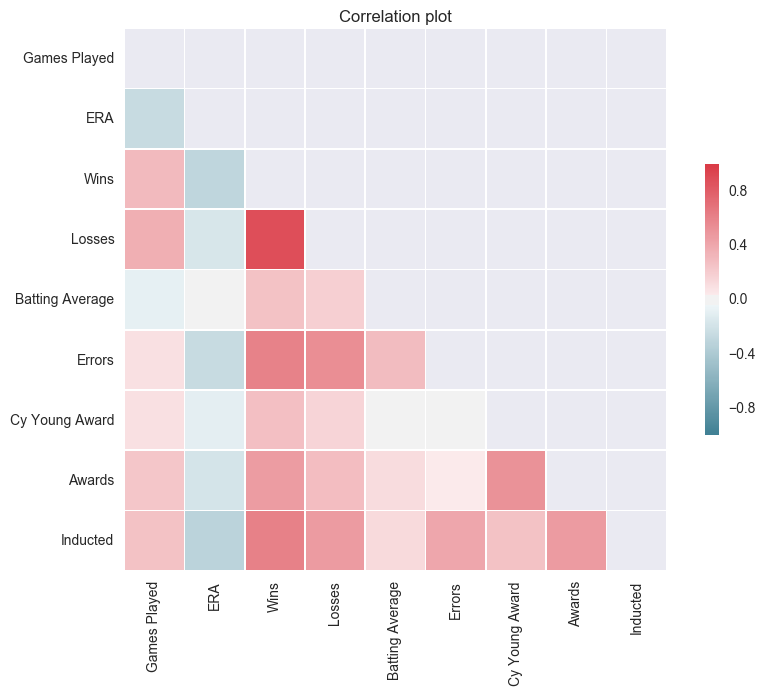

In [67]:
pitchers = nominated_players.loc[nominated_players.Position == 'P']

pitchers_corr = pitchers[['G_all', 'ERA', 'W', 'L', 'BA', 'E', 'Cy Young Award', 'Awards', 'inducted']].corr()
pitchers_corr.columns = ['Games Played', 'ERA', 'Wins', 'Losses', 'Batting Average', 'Errors', 'Cy Young Award', 'Awards', 'Inducted']

display(pitchers_corr.loc['inducted'].abs().sort_values())
corr_plot(pitchers_corr)

In [ ]:
# TODO: look at pitchers by era, see if BA changes as a predictor
# Early Baseball is 1871 to 1949

# Non-Pitchers

In [39]:
# Merge with Batting
non_pitchers = nominated_players.loc[nominated_players.Position != 'P']

The features most correlated with induction into the Hall of Fame are **Runs**, **Awards**, and **Hits.**

In [70]:
def fielding_corr_plot(df):
    corr = df[['A', 'E', 'DP', 'PB', 'WP', 'Opponent SB', 'Opponent CS', 'ZR', 'E/G', 'ZR/G', 'inducted']].corr()
    display(corr.loc['inducted'].abs().sort_values())
    corr_plot(corr)
    
    return corr

def batting_corr_plot(df):
    corr = df[['G_all', 'R', 'RBI', 'HR', 'H', 'SB', 'SO', 'BA', 'SLG', 'OBP', 'OPS', 'Awards','inducted']].corr()
    corr.columns = ['Games Played', 'Runs', 'Runs Batted In', 'Home Runs', 
                        'Hits', 'Stolen Bases', 'Strike Outs', 'Batting Average', 
                        'On-base Percentage', 'Slugging Average', 'On-base Plus Slugging', 'Awards',
                        'Inducted']
    display(corr.loc['inducted'].abs().sort_values())
    corr_plot(corr)
    
    return corr

No fielding stats seem to be particularly correlated with induction. At first I thought this might be an issue with cumulative stats, so I included metrics that counted Errors / Game and Zone Rating / G. 

Suggests a bias towards offensive statistics.

ZR/G           0.005756
E/G            0.068916
ZR             0.152955
WP             0.156271
DP             0.157303
A              0.168195
PB             0.169859
Opponent CS    0.229041
Opponent SB    0.279727
E              0.284245
inducted       1.000000
Name: inducted, dtype: float64

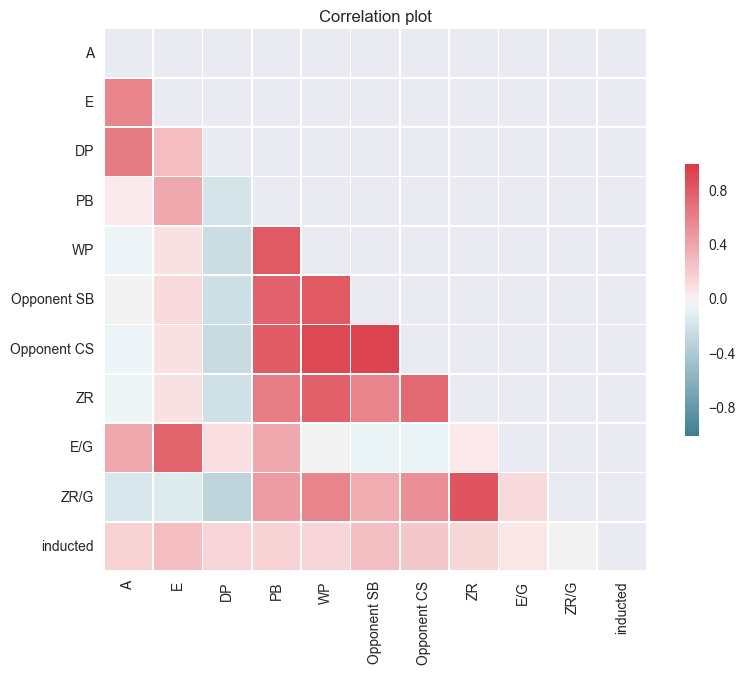

In [71]:
_ = fielding_corr_plot(non_pitchers)

Strike Outs              0.036438
Home Runs                0.238761
Stolen Bases             0.263113
On-base Percentage       0.338724
On-base Plus Slugging    0.390291
Slugging Average         0.400916
Games Played             0.406961
Batting Average          0.448893
Runs Batted In           0.492232
Hits                     0.523258
Awards                   0.535053
Runs                     0.545905
Inducted                 1.000000
Name: inducted, dtype: float64

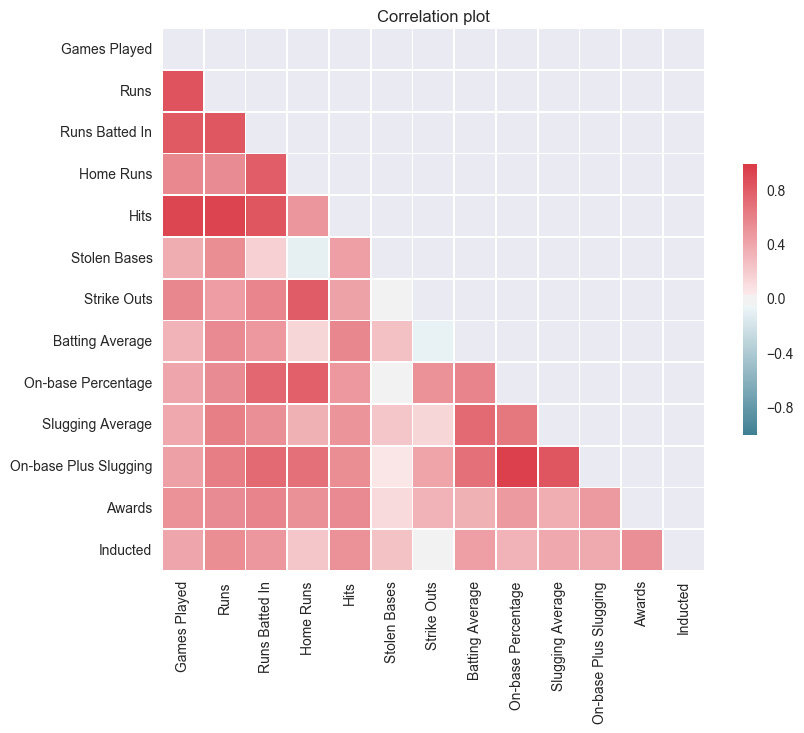

In [64]:
_ = batting_corr_plot(non_pitchers)

# Correlations by Positions
Let's break down non-pitchers further and see if these correlations change at all.

Top 5 correlations for each:
OF: Runs, Hits, RBI, Batting Average, RBI
SS: RBI, Awards, Runs, Hits, Slugging Average
2B: Awards, RBI, Hits, Runs, Games Played
C: Awards, RBI, Runs, OPS, OBP
1B: Runs, RBI, Hits, Batting Average, OPS
3B: Awards, Hits, BA, Runs, RBI
DH: Runs, Awards, Hits, RBI, SB

In [72]:
non_pitchers.Position.unique()

array(['OF', 'SS', '2B', 'C', '1B', '3B', 'DH', 'PH', 'LF', 'CF'], dtype=object)

OF
(295, 97)


Strike Outs              0.017700
Home Runs                0.214162
Stolen Bases             0.236681
On-base Percentage       0.333512
Games Played             0.384703
On-base Plus Slugging    0.399436
Slugging Average         0.417358
Awards                   0.471770
Runs Batted In           0.475613
Batting Average          0.481454
Hits                     0.528583
Runs                     0.560033
Inducted                 1.000000
Name: inducted, dtype: float64

A              0.055635
DP             0.098755
E/G            0.125744
E              0.346476
PB             0.705965
inducted       1.000000
WP                  NaN
Opponent SB         NaN
Opponent CS         NaN
ZR                  NaN
ZR/G                NaN
Name: inducted, dtype: float64

SS
(84, 97)


Strike Outs              0.057777
Home Runs                0.226031
Stolen Bases             0.354597
On-base Percentage       0.358905
On-base Plus Slugging    0.437156
Batting Average          0.464122
Games Played             0.466557
Slugging Average         0.467495
Hits                     0.576378
Runs                     0.590667
Awards                   0.597929
Runs Batted In           0.615088
Inducted                 1.000000
Name: inducted, dtype: float64

E/G            0.151643
DP             0.340276
E              0.392731
A              0.446932
inducted       1.000000
PB                  NaN
WP                  NaN
Opponent SB         NaN
Opponent CS         NaN
ZR                  NaN
ZR/G                NaN
Name: inducted, dtype: float64

2B
(88, 97)


Strike Outs              0.107471
Stolen Bases             0.344925
Home Runs                0.412602
Slugging Average         0.441782
Batting Average          0.447598
On-base Percentage       0.483052
On-base Plus Slugging    0.519868
Games Played             0.569471
Runs                     0.642920
Hits                     0.644631
Runs Batted In           0.646818
Awards                   0.715629
Inducted                 1.000000
Name: inducted, dtype: float64

E/G            0.066583
E              0.271817
DP             0.550832
A              0.616043
PB             0.857816
WP             1.000000
Opponent SB    1.000000
Opponent CS    1.000000
ZR             1.000000
ZR/G           1.000000
inducted       1.000000
Name: inducted, dtype: float64

C
(101, 97)


Strike Outs              0.142733
Stolen Bases             0.293404
Games Played             0.399031
Batting Average          0.402330
Slugging Average         0.426341
Home Runs                0.494682
Hits                     0.496819
On-base Percentage       0.502441
On-base Plus Slugging    0.510052
Runs                     0.588230
Runs Batted In           0.591491
Awards                   0.631389
Inducted                 1.000000
Name: inducted, dtype: float64

E/G            0.040726
ZR/G           0.091960
PB             0.094910
WP             0.100090
ZR             0.120910
E              0.180416
DP             0.200555
Opponent CS    0.204366
Opponent SB    0.246607
A              0.288862
inducted       1.000000
Name: inducted, dtype: float64

1B
(100, 97)


Strike Outs              0.061700
Home Runs                0.247375
Stolen Bases             0.255670
Games Played             0.342032
Awards                   0.387126
Slugging Average         0.410915
On-base Percentage       0.427247
On-base Plus Slugging    0.463361
Batting Average          0.475765
Hits                     0.477404
Runs Batted In           0.528945
Runs                     0.553022
Inducted                 1.000000
Name: inducted, dtype: float64

PB             0.116275
DP             0.225104
E/G            0.248210
A              0.356788
E              0.435633
inducted       1.000000
WP                  NaN
Opponent SB         NaN
Opponent CS         NaN
ZR                  NaN
ZR/G                NaN
Name: inducted, dtype: float64

3B
(86, 97)


Stolen Bases             0.014135
Strike Outs              0.039843
Home Runs                0.199242
Slugging Average         0.302273
On-base Percentage       0.324607
Games Played             0.347225
On-base Plus Slugging    0.364685
Runs Batted In           0.441174
Runs                     0.475953
Batting Average          0.491384
Hits                     0.498727
Awards                   0.598052
Inducted                 1.000000
Name: inducted, dtype: float64

E/G            0.035455
DP             0.178187
E              0.240369
A              0.323551
PB             0.788142
inducted       1.000000
WP                  NaN
Opponent SB         NaN
Opponent CS         NaN
ZR                  NaN
ZR/G                NaN
Name: inducted, dtype: float64

DH
(8, 97)


Games Played             0.358790
Home Runs                0.396750
On-base Percentage       0.401477
On-base Plus Slugging    0.429059
Slugging Average         0.429113
Strike Outs              0.454728
Batting Average          0.456517
Stolen Bases             0.467663
Runs Batted In           0.508401
Hits                     0.623047
Awards                   0.666073
Runs                     0.785281
Inducted                 1.000000
Name: inducted, dtype: float64

E/G            0.511707
E              0.642263
A              0.654115
DP             0.837302
inducted       1.000000
PB                  NaN
WP                  NaN
Opponent SB         NaN
Opponent CS         NaN
ZR                  NaN
ZR/G                NaN
Name: inducted, dtype: float64

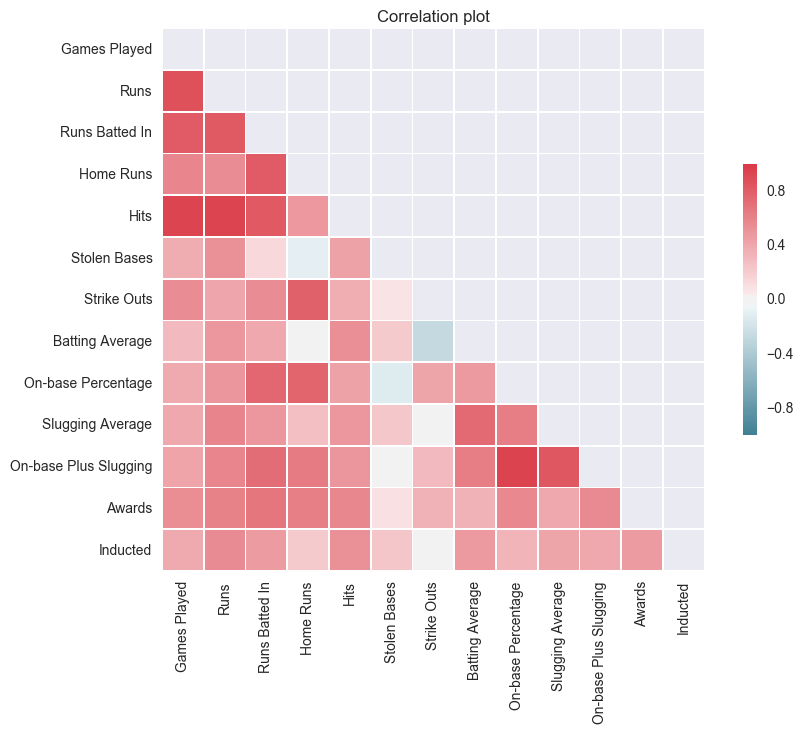

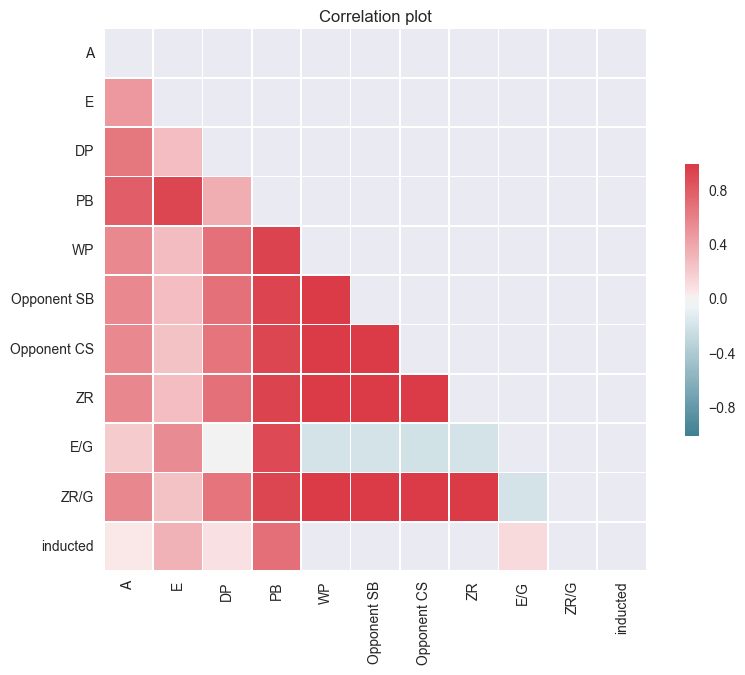

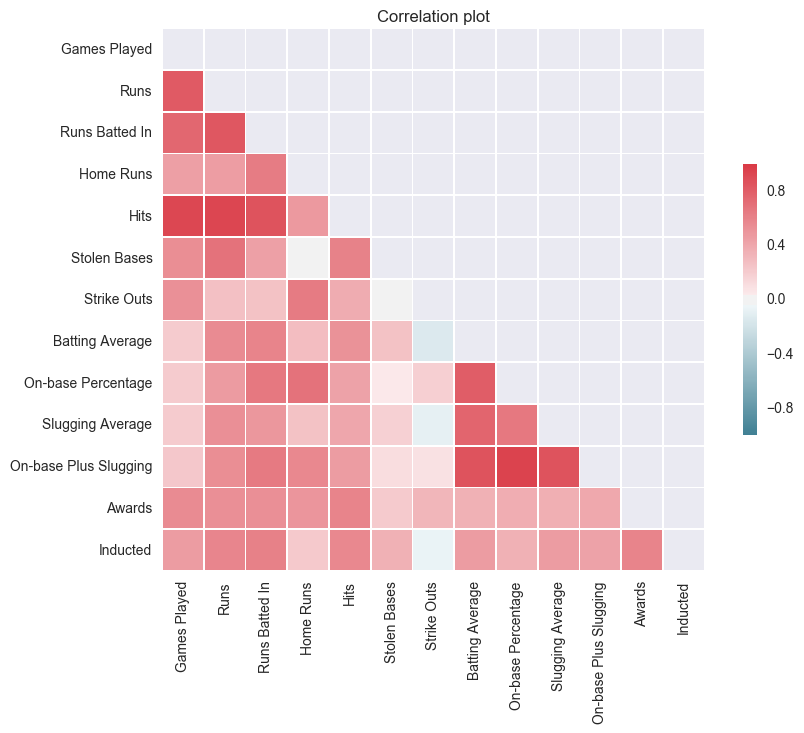

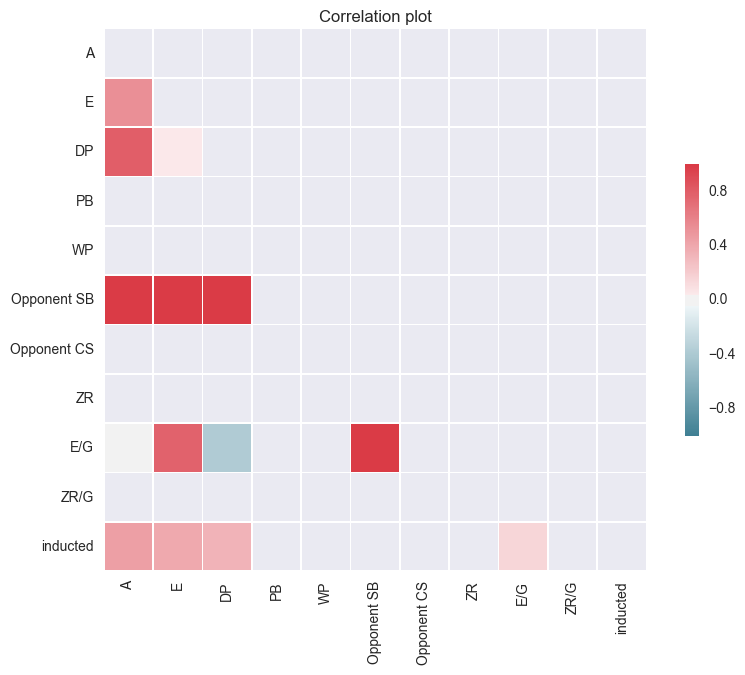

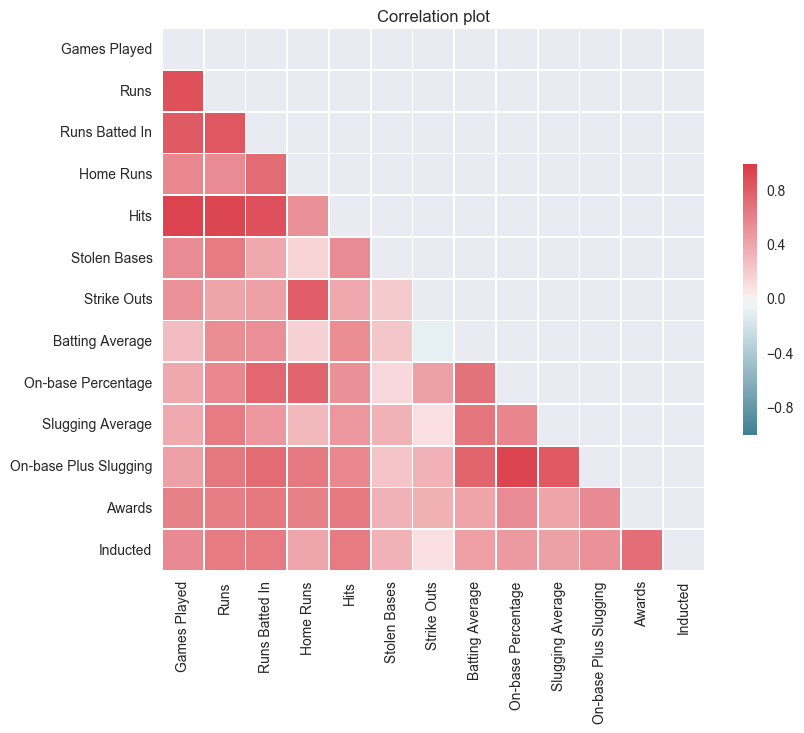

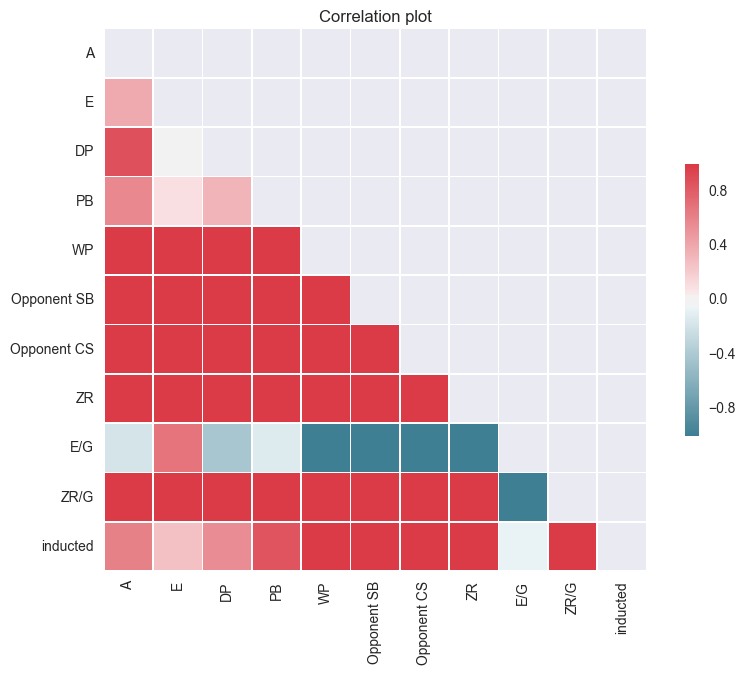

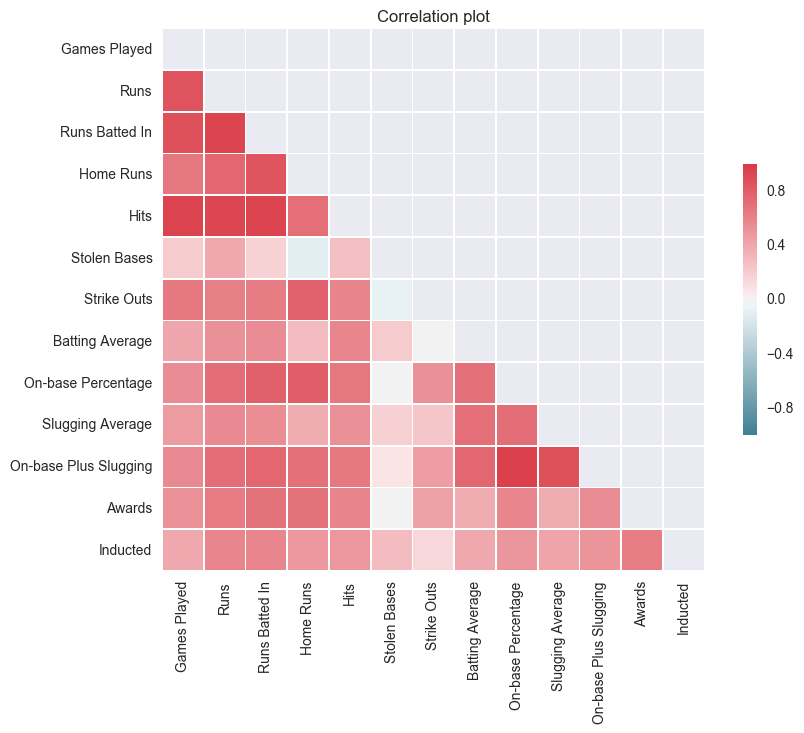

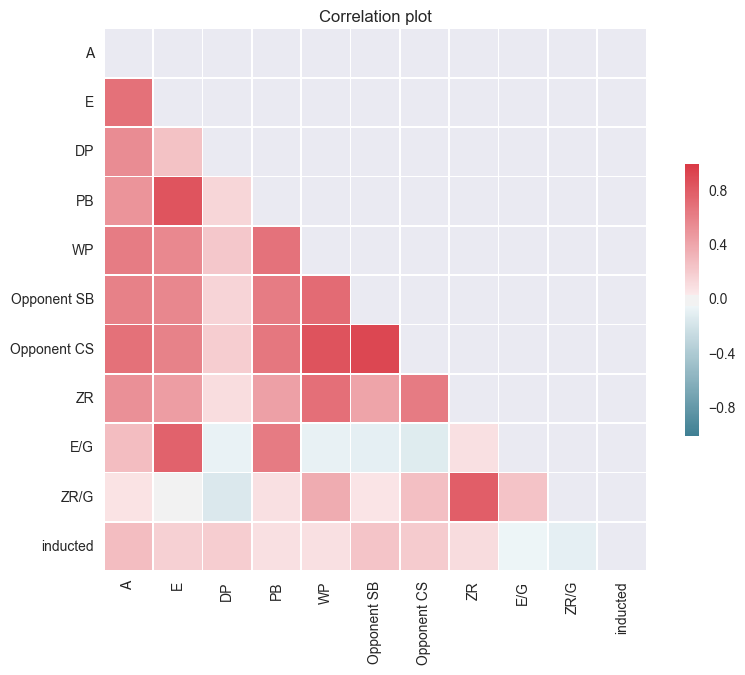

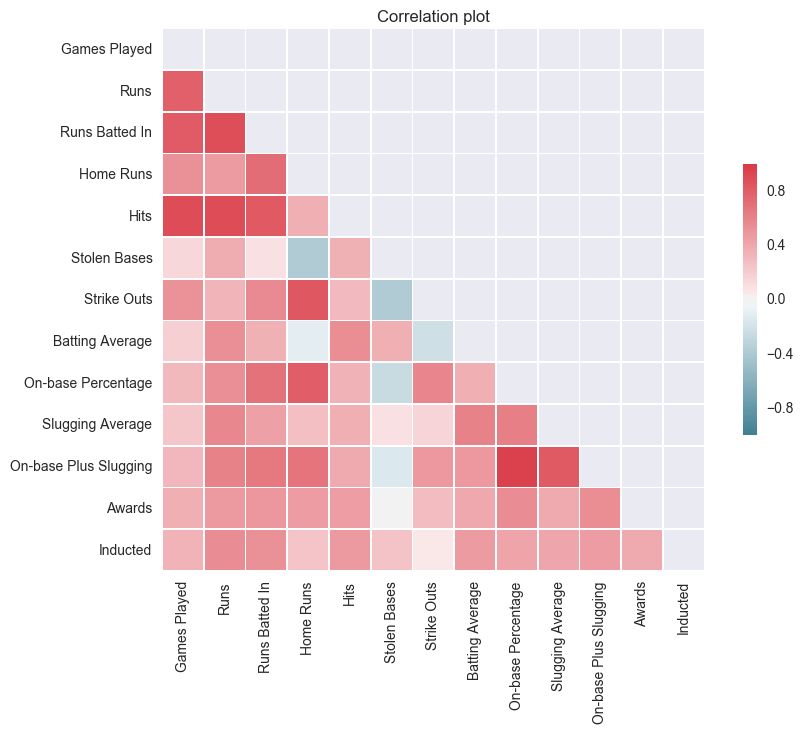

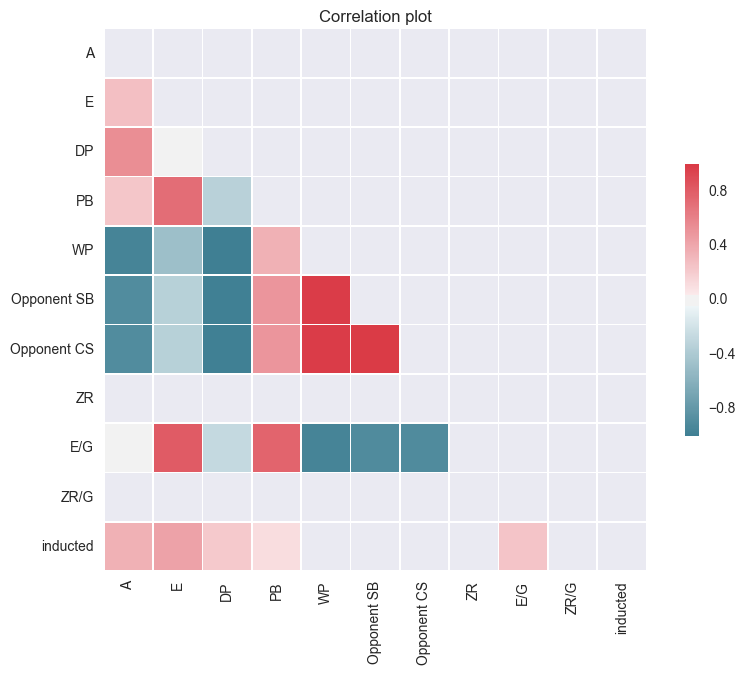

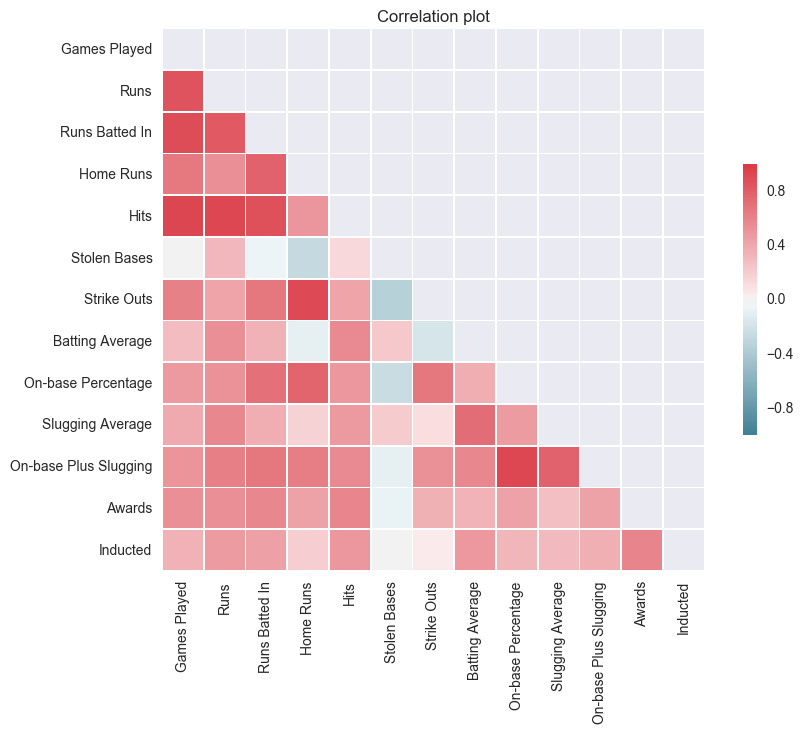

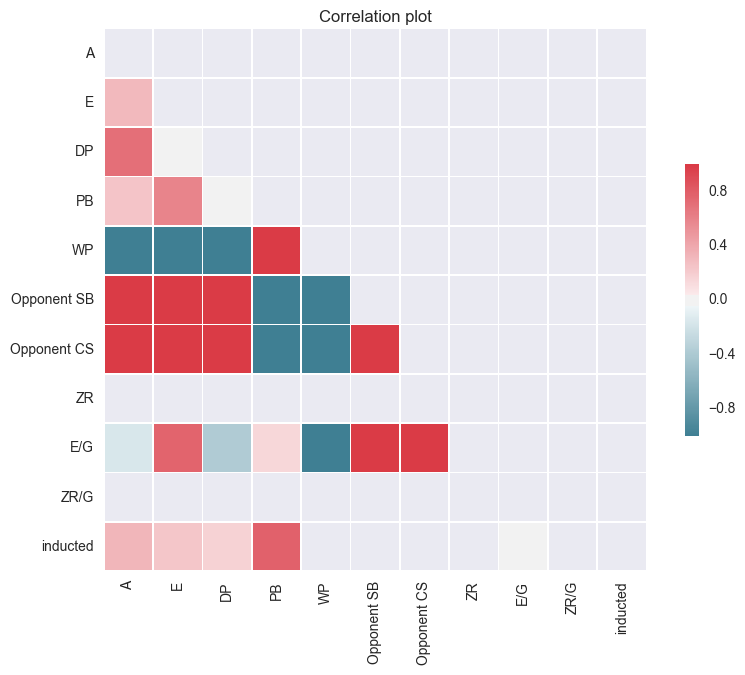

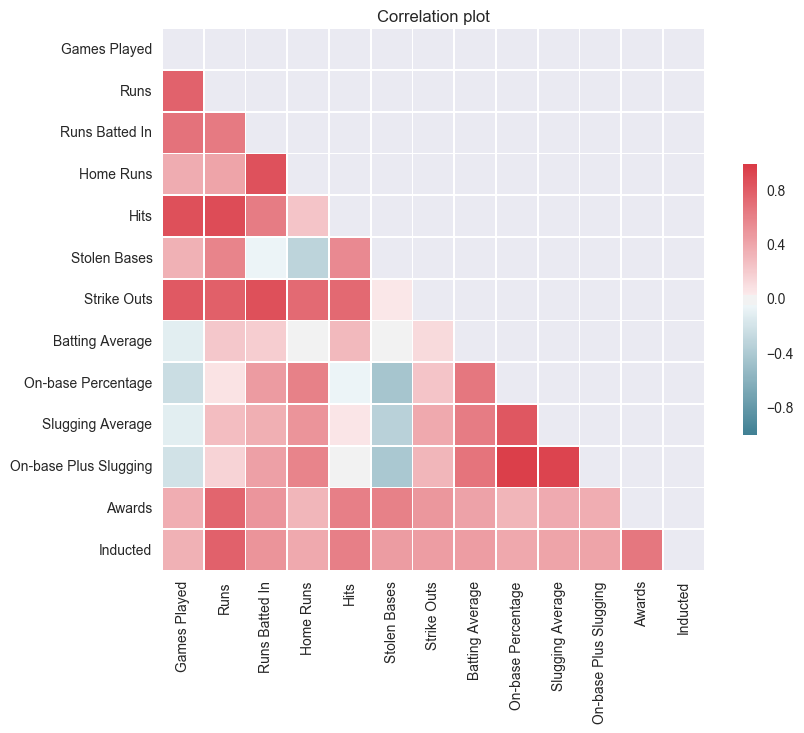

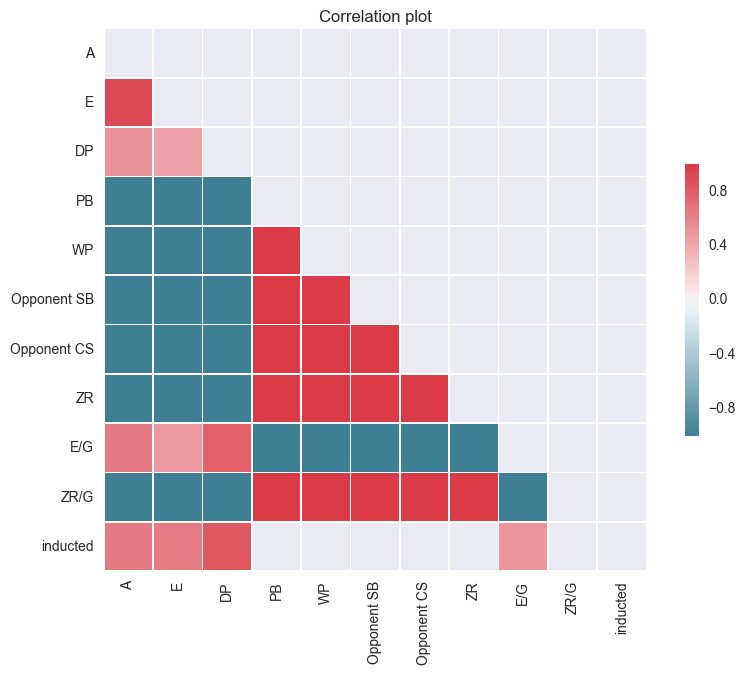

In [75]:
positions = ['OF', 'SS', '2B', 'C', '1B', '3B', 'DH']

for pos in positions:
    print(pos)
    print(non_pitchers.loc[non_pitchers.Position == pos].shape)
    batting_corr_plot(non_pitchers.loc[non_pitchers.Position == pos])
    fielding_corr_plot(non_pitchers.loc[non_pitchers.Position == pos])

In [78]:
non_pitchers.loc[(non_pitchers.Position == 'OF') & (non_pitchers['PB'] > 0)]

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards,G_all,GS_x,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,ERA,W,L,stint_x,G_x,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,BA,SLG,OBP,OPS,stint_y,G_y,GS_y,InnOuts,PO,A,E,DP,PB,WP,Opponent SB,Opponent CS,ZR,E/G,ZR/G
25,kellyki01,King,Kelly,OF,1945,Old Timers,0.0,0.0,0.0,1,Player,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1455.0,0.0,1455,1455.0,12,583,25,54,96,90,2,8,742,750,0.0,0.0,0.0,3.311429,2.0,2.0,21,1455,5894.0,1357.0,1813.0,359.0,102.0,69.0,950.0,368.0,0.0,549.0,418.0,0.0,12.0,0.0,0.0,0.0,0.307601,0.438242,0.367777,0.806019,82,1610,NaN,NaN,3572.0,1749.0,851.0,145.0,417.0,NaN,NaN,NaN,NaN,0.528571,NaN
92,orourji01,Jim,O'Rourke,OF,1945,Old Timers,0.0,0.0,0.0,1,Player,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999.0,0.0,1999,1999.0,6,231,214,2,148,40,770,463,217,1443,0.0,0.0,0.0,4.635000,0.0,1.0,23,1999,8505.0,1729.0,2643.0,465.0,151.0,62.0,1203.0,224.0,8.0,510.0,360.0,0.0,36.0,0.0,0.0,0.0,0.310758,0.422810,0.352337,0.775147,72,2079,NaN,NaN,5485.0,947.0,696.0,170.0,196.0,NaN,NaN,NaN,NaN,0.334776,NaN
262,bauerha01,Hank,Bauer,OF,1967,Run Off,306.0,219.0,9.0,0,Player,1st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1544.0,0.0,1544,1544.0,0,1,0,0,0,0,177,29,1292,1449,0.0,0.0,0.0,0.000000,0.0,0.0,14,1544,5145.0,833.0,1424.0,229.0,57.0,164.0,703.0,50.0,33.0,521.0,638.0,11.0,34.0,51.0,25.0,95.0,0.276774,0.439067,0.345677,0.784744,31,2328,1492.0,40159.0,3710.0,157.0,76.0,28.0,1.0,0.0,0.0,0.0,0.0,0.032646,0.000000
356,cartyri01,Rico,Carty,OF,1985,BBWAA,395.0,297.0,1.0,0,Player,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1651.0,653.0,1651,1004.0,0,17,59,0,1,0,789,1,18,807,598.0,53.0,0.0,0.000000,0.0,0.0,22,1651,5606.0,712.0,1677.0,278.0,17.0,204.0,890.0,21.0,26.0,642.0,663.0,65.0,13.0,3.0,54.0,206.0,0.299144,0.463967,0.369279,0.833247,47,2342,1642.0,40572.0,3116.0,98.0,96.0,57.0,2.0,5.0,6.0,5.0,0.0,0.040991,0.000000
692,langebi01,Bill,Lange,OF,1953,BBWAA,264.0,198.0,1.0,0,Player,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,813.0,0.0,813,813.0,0,8,16,57,9,9,15,702,2,718,0.0,0.0,0.0,0.000000,0.0,0.0,7,811,3195.0,689.0,1055.0,133.0,80.0,39.0,578.0,399.0,0.0,350.0,86.0,0.0,25.0,39.0,0.0,0.0,0.330203,0.458529,0.400560,0.859089,16,815,NaN,NaN,2108.0,387.0,183.0,76.0,7.0,NaN,NaN,NaN,NaN,0.224540,NaN
819,motama01,Manny,Mota,OF,1989,BBWAA,447.0,336.0,9.0,0,Player,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1536.0,8.0,1536,1244.0,0,1,0,6,15,0,726,270,118,1022,0.0,300.0,0.0,0.000000,0.0,0.0,22,1536,3779.0,496.0,1149.0,125.0,52.0,31.0,438.0,50.0,42.0,289.0,320.0,43.0,28.0,95.0,36.0,99.0,0.304049,0.389256,0.354792,0.744048,72,2160,1577.0,44584.0,2920.0,141.0,68.0,29.0,2.0,0.0,0.0,0.0,0.0,0.031481,0.000000
827,murphda05,Dale,Murphy,OF,2013,BBWAA,569.0,427.0,106.0,0,Player,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,2.0,4.0,0.0,0.0,2.0,0.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,19.0,2180.0,2107.0,2180,2142.0,0,85,209,0,0,0,103,1041,749,1854,0.0,55.0,2.0,0.000000,0.0,0.0,20

## Steroids Era Analysis

In [79]:
non_pitchers = pd.merge(non_pitchers, master_df[['playerID', 'finalGame']], on='playerID')

In [80]:
non_pitchers['Final Year'] = pd.DatetimeIndex(non_pitchers['finalGame']).year
sum((non_pitchers['Final Year'] - 1994) >= 5)

128

In [81]:
non_steroids_era = non_pitchers.loc[non_pitchers['Final Year'] - 1994 < 5]
steroids_era = non_pitchers.loc[non_pitchers['Final Year'] - 1994 >= 5]

display(non_steroids_era.shape)
display(steroids_era.shape)

(640, 99)

(128, 99)

Strike Outs              0.107125
Stolen Bases             0.277262
Home Runs                0.327522
On-base Percentage       0.427277
Slugging Average         0.428173
Games Played             0.441952
On-base Plus Slugging    0.460672
Batting Average          0.467331
Awards                   0.549761
Hits                     0.558178
Runs Batted In           0.568051
Runs                     0.593983
Inducted                 1.000000
Name: inducted, dtype: float64

ZR/G           0.035280
E/G            0.039757
A              0.155641
PB             0.176241
DP             0.179603
WP             0.207984
ZR             0.230902
Opponent SB    0.266087
E              0.268064
Opponent CS    0.282128
inducted       1.000000
Name: inducted, dtype: float64

,A,E,DP,PB,WP,Opponent SB,Opponent CS,ZR,E/G,ZR/G,inducted
A,1.000000,0.611365,0.650561,0.077164,0.009410,0.013174,0.019385,0.026792,0.396052,-0.110927,0.155641
E,0.611365,1.000000,0.323625,0.401898,0.156665,0.161846,0.164448,0.145458,0.752930,-0.094292,0.268064
DP,0.650561,0.323625,1.000000,-0.151638,-0.162116,-0.158573,-0.165031,-0.157047,0.116181,-0.263499,0.179603
PB,0.077164,0.401898,-0.151638,1.000000,0.839392,0.773320,0.802710,0.634821,0.400107,0.462649,0.176241
WP,0.009410,0.156665,-0.162116,0.839392,1.000000,0.919509,0.949932,0.817457,0.016892,0.602846,0.207984
Opponent SB,0.013174,0.161846,-0.158573,0.773320,0.919509,1.000000,0.975543,0.719462,-0.017893,0.487880,0.266087
Opponent CS,0.019385,0.164448,-0.165031,0.802710,0.949932,0.975543,1.000000,0.818800,-0.002606,0.583818,0.282128
ZR,0.026792,0.145458,-0.157047,0.634821,0.817457,0.719462,0.818800,1.000000,0.087406,0.837607,0.230902
E/G,0.396052,0.752930,0.116181,0.400107,0.016892,-0.017893,-0.002606,0.087406,1.000000,0.186151,0.039757
ZR/G,-0.110927,-0.094292,-0.263499,0.462649,0.602846,0.487880,0.583818,0.837607,0.186151,1.000000,0.035280


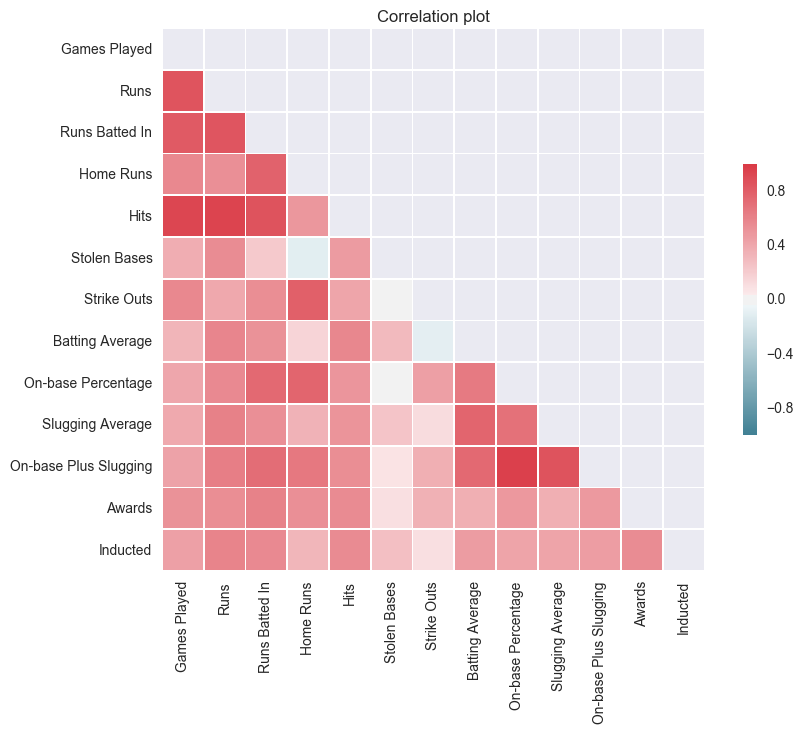

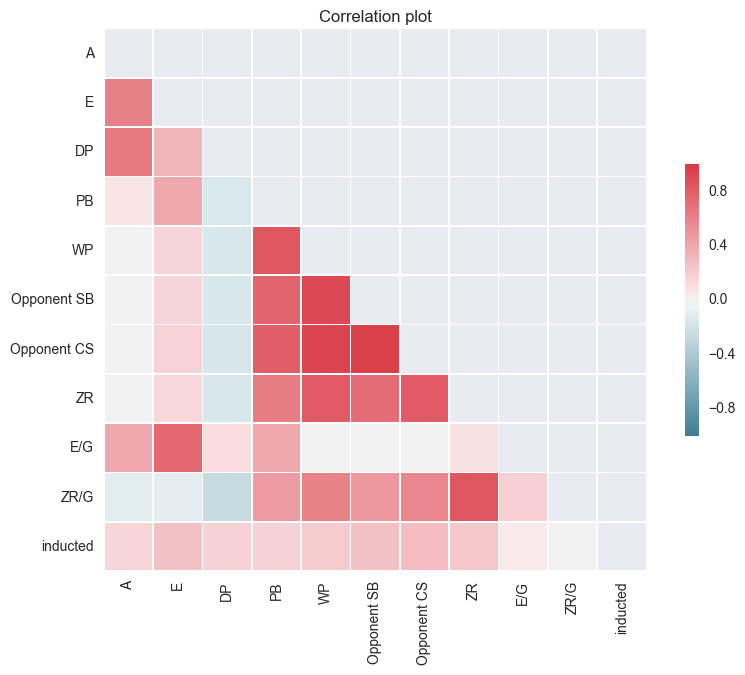

In [85]:
non_steroids_corr = batting_corr_plot(non_steroids_era)
fielding_corr_plot(non_steroids_era)

Strike Outs              0.088456
On-base Percentage       0.089703
Home Runs                0.159846
On-base Plus Slugging    0.180214
Runs Batted In           0.260480
Stolen Bases             0.276848
Slugging Average         0.301905
Batting Average          0.318515
Games Played             0.405887
Runs                     0.464748
Hits                     0.486375
Awards                   0.613070
Inducted                 1.000000
Name: inducted, dtype: float64

Opponent CS    0.012099
WP             0.020455
PB             0.053347
E/G            0.061150
ZR             0.085632
ZR/G           0.105649
DP             0.106853
A              0.261737
E              0.287917
Opponent SB    0.292576
inducted       1.000000
Name: inducted, dtype: float64

,A,E,DP,PB,WP,Opponent SB,Opponent CS,ZR,E/G,ZR/G,inducted
A,1.000000,0.661216,0.589391,-0.310767,-0.242249,-0.257590,-0.356450,-0.137000,0.733520,-0.183775,0.261737
E,0.661216,1.000000,0.269559,-0.134790,-0.142921,-0.160407,-0.280090,0.039557,0.640733,-0.031636,0.287917
DP,0.589391,0.269559,1.000000,-0.642201,-0.499946,-0.616005,-0.692440,-0.282735,0.404674,-0.328635,0.106853
PB,-0.310767,-0.134790,-0.642201,1.000000,0.775172,0.862450,0.877852,0.780398,-0.209272,0.793910,0.053347
WP,-0.242249,-0.142921,-0.499946,0.775172,1.000000,0.607982,0.762398,0.662902,-0.244455,0.671495,-0.020455
Opponent SB,-0.257590,-0.160407,-0.616005,0.862450,0.607982,1.000000,0.915472,0.413837,-0.293704,0.430556,0.292576
Opponent CS,-0.356450,-0.280090,-0.692440,0.877852,0.762398,0.915472,1.000000,0.533125,-0.394271,0.553703,0.012099
ZR,-0.137000,0.039557,-0.282735,0.780398,0.662902,0.413837,0.533125,1.000000,-0.035832,0.988005,-0.085632
E/G,0.733520,0.640733,0.404674,-0.209272,-0.244455,-0.293704,-0.394271,-0.035832,1.000000,-0.066769,0.061150
ZR/G,-0.183775,-0.031636,-0.328635,0.793910,0.671495,0.430556,0.553703,0.988005,-0.066769,1.000000,-0.105649


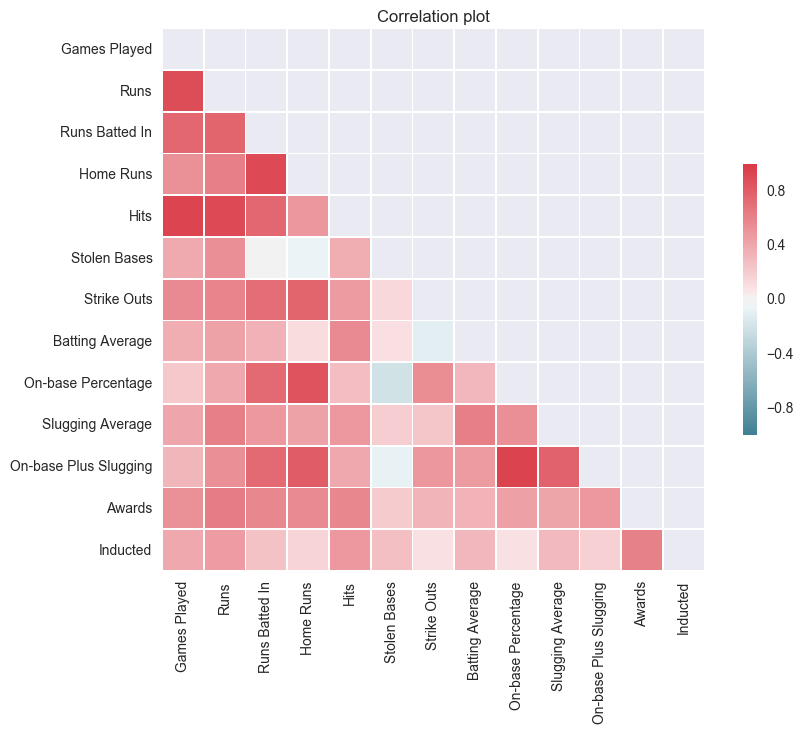

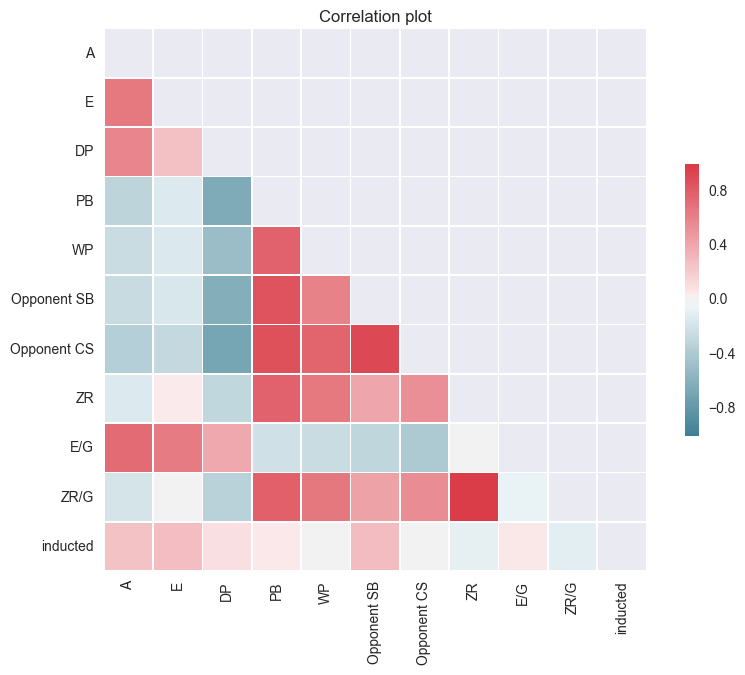

In [84]:
steroids_corr = batting_corr_plot(steroids_era)
fielding_corr_plot(steroids_era)

In [ ]:
steroids_corr['Inducted'] - non_steroids_corr['Inducted']

In [ ]:
# TODO: investigate whether there is a backlog in the Hall of Fame
# How many players get voted in per year?

# Conclusion
For pitchers, cumulative statistics such as wins and number of awards were most correlated with induction into the Hall of Fame. 
For non-pitchers, runs scored, hits, and awards were the most highly correlated with induction.

There are other directions I'd like to go in with this analysis:

* (/) Add more player data, including fielding statistics. 
* Compare players voted in by different methods. Are there differences between players voted in via the Baseball Writers vs. the Veterans Committee?
* Compare players from different eras. The modern game is dominated by newer metrics of player performance. Have voters opinions changed as a result of this?